## INFOSYS 722 Assignement Iteration 4

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
spark = SparkSession.builder.appName('infosys722-i4').getOrCreate()

### Read Raw Data

In [3]:
raw_data_products = spark.read.options(compression='gzip').csv('./Datasets/2017PurchasePricesDec.csv.gz', inferSchema=True, header=True)
raw_data_inventory = spark.read.options(compression='gzip').csv('./Datasets/BegInvFINAL12312016.csv.gz', inferSchema=True, header=True)
raw_data_inventory_end = spark.read.options(compression='gzip').csv('./Datasets/EndInvFINAL12312016.csv.gz', inferSchema=True, header=True)
raw_data_purchase_order = spark.read.options(compression='gzip').csv('./Datasets/InvoicePurchases12312016.csv.gz', inferSchema=True, header=True)
raw_data_purchase_detail = spark.read.options(compression='gzip').csv('./Datasets/PurchasesFINAL12312016.csv.gz', inferSchema=True, header=True)
raw_data_sales = spark.read.options(compression='gzip').csv('./Datasets/SalesFINAL12312016.csv.gz', inferSchema=True, header=True)

### Data Understanding, Data Cleaning and Data Preparation

#### Describe Data

In [4]:
raw_data_products.head()

Row(Brand=58, Description='Gekkeikan Black & Gold Sake', Price=12.99, Size='750mL', Volume='750', Classification=1, PurchasePrice=9.28, VendorNumber=8320, VendorName='SHAW ROSS INT L IMP LTD    ')

In [5]:
raw_data_inventory.head()

Row(InventoryId='1_HARDERSFIELD_58', Store=1, City='HARDERSFIELD', Brand=58, Description='Gekkeikan Black & Gold Sake', Size='750mL', onHand=8, Price=12.99, startDate=datetime.date(2016, 1, 1))

In [6]:
raw_data_inventory_end.head()

Row(InventoryId='1_HARDERSFIELD_58', Store=1, City='HARDERSFIELD', Brand=58, Description='Gekkeikan Black & Gold Sake', Size='750mL', onHand=11, Price=12.99, endDate=datetime.date(2016, 12, 31))

In [7]:
raw_data_purchase_order.head()

Row(VendorNumber=105, VendorName='ALTAMAR BRANDS LLC         ', InvoiceDate=datetime.date(2016, 1, 4), PONumber=8124, PODate=datetime.date(2015, 12, 21), PayDate=datetime.date(2016, 2, 16), Quantity=6, Dollars=214.26, Freight=3.47, Approval='None')

In [8]:
raw_data_purchase_detail.head()

Row(InventoryId='69_MOUNTMEND_8412', Store=69, Brand=8412, Description='Tequila Ocho Plata Fresno', Size='750mL', VendorNumber=105, VendorName='ALTAMAR BRANDS LLC         ', PONumber=8124, PODate=datetime.date(2015, 12, 21), ReceivingDate=datetime.date(2016, 1, 2), InvoiceDate=datetime.date(2016, 1, 4), PayDate=datetime.date(2016, 2, 16), PurchasePrice=35.71, Quantity=6, Dollars=214.26, Classification=1)

In [9]:
raw_data_sales.head()

Row(InventoryId='1_HARDERSFIELD_1004', Store=1, Brand=1004, Description='Jim Beam w/2 Rocks Glasses', Size='750mL', SalesQuantity=1, SalesDollars=16.49, SalesPrice=16.49, SalesDate='1/1/2016', Volume=750, Classification=1, ExciseTax=0.79, VendorNo=12546, VendorName='JIM BEAM BRANDS COMPANY    ')

In [10]:
def print_summary(dataframe):
    summary = dataframe.summary()
    columns = ['feature'] + [row['summary'] for row in summary.collect()]
    data = []
    for feature in summary.columns[1:]:
        data.append([feature, *[row[feature] for row in summary.collect()]])
    spark.createDataFrame(data, schema=columns).show()

In [11]:
raw_data_products.printSchema()
print_summary(raw_data_products)

root
 |-- Brand: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Size: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Classification: integer (nullable = true)
 |-- PurchasePrice: double (nullable = true)
 |-- VendorNumber: integer (nullable = true)
 |-- VendorName: string (nullable = true)

+--------------+-----+------------------+------------------+--------------------+-----+-----+-----+--------------------+
|       feature|count|              mean|            stddev|                 min|  25%|  50%|  75%|                 max|
+--------------+-----+------------------+------------------+--------------------+-----+-----+-----+--------------------+
|         Brand|12261|17989.067123399396|12528.503463986654|                  58| 5989|18787|25113|               90631|
|   Description|12260|              null|              null|              (RI) 1| null| null| null|   von Buhl Jazz Rsl|
|         Price|12

In [12]:
raw_data_inventory.printSchema()
print_summary(raw_data_inventory)

root
 |-- InventoryId: string (nullable = true)
 |-- Store: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Brand: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- onHand: integer (nullable = true)
 |-- Price: double (nullable = true)
 |-- startDate: date (nullable = true)

+-----------+------+------------------+------------------+--------------------+----+-----+-----+-----------------+
|    feature| count|              mean|            stddev|                 min| 25%|  50%|  75%|              max|
+-----------+------+------------------+------------------+--------------------+----+-----+-----+-----------------+
|InventoryId|206529|              null|              null|     10_HORNSEY_1000|null| null| null|  9_BLACKPOOL_999|
|      Store|206529| 42.12245737886689|23.191393409648104|                   1|  22|   42|   64|               79|
|       City|206529|              null|              null|            

In [13]:
raw_data_inventory_end.printSchema()
print_summary(raw_data_inventory_end)

root
 |-- InventoryId: string (nullable = true)
 |-- Store: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Brand: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- onHand: integer (nullable = true)
 |-- Price: double (nullable = true)
 |-- endDate: date (nullable = true)

+-----------+------+------------------+------------------+--------------------+----+-----+-----+-----------------+
|    feature| count|              mean|            stddev|                 min| 25%|  50%|  75%|              max|
+-----------+------+------------------+------------------+--------------------+----+-----+-----+-----------------+
|InventoryId|224489|              null|              null|     10_HORNSEY_1001|null| null| null|  9_BLACKPOOL_984|
|      Store|224489|43.505739702168036|23.326415082417782|                   1|  23|   44|   66|               81|
|       City|223205|              null|              null|            AB

In [14]:
raw_data_purchase_order.printSchema()
print_summary(raw_data_purchase_order)

root
 |-- VendorNumber: integer (nullable = true)
 |-- VendorName: string (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PONumber: integer (nullable = true)
 |-- PODate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: double (nullable = true)
 |-- Freight: double (nullable = true)
 |-- Approval: string (nullable = true)

+------------+-----+------------------+------------------+--------------------+------+-------+--------+--------------------+
|     feature|count|              mean|            stddev|                 min|   25%|    50%|     75%|                 max|
+------------+-----+------------------+------------------+--------------------+------+-------+--------+--------------------+
|VendorNumber| 5543|20662.752119790726| 34582.15840981278|                   2|  3089|   7240|   10754|              201359|
|  VendorName| 5543|              null|              null|AAPER ALCOHOL & C...|  null|   null

In [15]:
raw_data_purchase_detail.printSchema()
print_summary(raw_data_purchase_detail)

root
 |-- InventoryId: string (nullable = true)
 |-- Store: integer (nullable = true)
 |-- Brand: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- VendorNumber: integer (nullable = true)
 |-- VendorName: string (nullable = true)
 |-- PONumber: integer (nullable = true)
 |-- PODate: date (nullable = true)
 |-- ReceivingDate: date (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- PurchasePrice: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: double (nullable = true)
 |-- Classification: integer (nullable = true)

+--------------+-------+------------------+------------------+--------------------+-----+-----+------+--------------------+
|       feature|  count|              mean|            stddev|                 min|  25%|  50%|   75%|                 max|
+--------------+-------+------------------+------------------+--------------------+-----+--

In [16]:
raw_data_sales.printSchema()
print_summary(raw_data_sales)

root
 |-- InventoryId: string (nullable = true)
 |-- Store: integer (nullable = true)
 |-- Brand: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesDollars: double (nullable = true)
 |-- SalesPrice: double (nullable = true)
 |-- SalesDate: string (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: integer (nullable = true)
 |-- ExciseTax: double (nullable = true)
 |-- VendorNo: integer (nullable = true)
 |-- VendorName: string (nullable = true)

+--------------+-------+------------------+-------------------+--------------------+-----+-----+-----+--------------------+
|       feature|  count|              mean|             stddev|                 min|  25%|  50%|  75%|                 max|
+--------------+-------+------------------+-------------------+--------------------+-----+-----+-----+--------------------+
|   InventoryId|1048575|              nul

#### Data Cleaning - Replace invalid data, Correct measurement error, Correct date format, Align features' names

In [17]:
def replace(dataframe, column, condition, new_value):
    return dataframe.withColumn(column, F.when(condition, new_value).otherwise(dataframe[column]))

#
# replace invalid value
#
raw_data_products = replace(raw_data_products, 'Volume', raw_data_products['Volume'].isNull(), 0)
raw_data_products = replace(raw_data_products, 'Volume', raw_data_products['Volume'] == 'Unknown', 0)
raw_data_products = replace(raw_data_products, 'Volume', raw_data_products['Volume'] == '162.5', 162)

#
# Correct Data Type
#
dtype_products = {
    'Brand': 'string',
    'Description': 'string',
    'Price': 'float',
    'Size': 'string',
    'Volume': 'int',
    'Classification': 'string',
    'PurchasePrice': 'float',
    'VendorNumber': 'string',
    'VendorName': 'string',
}
    
dtype_inventory_begin = {    
    'InventoryId': 'string',
    'Store': 'string',
    'City': 'string',
    'Brand': 'string',
    'Description': 'string',
    'Size': 'string',
    'onHand': 'int',
    'Price': 'float',
    'startDate': 'string',
}    

dtype_inventory_end = { 
    'InventoryId': 'string',
    'Store': 'string',
    'City': 'string',
    'Brand': 'string',
    'Description': 'string',
    'Size': 'string',
    'onHand': 'int',
    'Price': 'float',
    'endDate': 'string',
}    

dtype_purchase_order = {    
    'VendorNumber': 'string',
    'VendorName': 'string',
    'InvoiceDate': 'string',
    'PONumber': 'string',
    'PODate': 'string',
    'PayDate': 'string',
    'Quantity': 'int',
    'Dollars': 'float',
    'Freight': 'float',
    'Approval': 'string',
}

dtype_purchase_detail = {
    'InventoryId': 'string',
    'Store': 'string',
    'Brand': 'string',
    'Description': 'string',
    'Size': 'string',
    'VendorNumber': 'string',
    'VendorName': 'string',
    'PONumber': 'string',
    'PODate': 'string',
    'ReceivingDate': 'string',
    'InvoiceDate': 'string',
    'PayDate': 'string',
    'PurchasePrice': 'float',
    'Quantity': 'int',
    'Dollars': 'float',
    'Classification': 'string',
}   
    
dtype_sales = {    
    'InventoryId': 'string',
    'Store': 'string',
    'Brand': 'string',
    'Description': 'string',
    'Size': 'string',
    'SalesQuantity': 'int',
    'SalesDollars': 'float',
    'SalesPrice': 'float',
    'SalesDate': 'string',
    'Volume': 'int',
    'Classification': 'string',
    'ExciseTax': 'float',
    'VendorNo': 'string',
    'VendorName': 'string',
}

def correct_dtype(dataframe, dtype_dict):
    for column, dtype in dtype_dict.items():
        dataframe = dataframe.withColumn(column, F.col(column).cast(dtype))
    return dataframe

raw_data_products = correct_dtype(raw_data_products, dtype_products)
raw_data_inventory = correct_dtype(raw_data_inventory, dtype_inventory_begin)
raw_data_inventory_end = correct_dtype(raw_data_inventory_end, dtype_inventory_end)
raw_data_purchase_order = correct_dtype(raw_data_purchase_order, dtype_purchase_order)
raw_data_purchase_detail = correct_dtype(raw_data_purchase_detail, dtype_purchase_detail)
raw_data_sales = correct_dtype(raw_data_sales, dtype_sales)

#
# Convert date string to datetime
#

def format_date(dataframe, columns, date_format='yyyy-MM-dd'):
    for column in columns:
        dataframe = dataframe.withColumn(column, F.to_date(column, date_format))
    return dataframe
        
raw_data_inventory = format_date(raw_data_inventory, ['startDate'])
raw_data_inventory_end = format_date(raw_data_inventory_end, ['endDate'])
raw_data_purchase_order = format_date(raw_data_purchase_order, ['PODate', 'InvoiceDate', 'PayDate'])
raw_data_purchase_detail = format_date(raw_data_purchase_detail, ['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate'])
raw_data_sales = format_date(raw_data_sales, ['SalesDate'], date_format = 'M/d/yyyy')

#
# Align features' name across datasets
#
# VendorNo in Sales should be renamed to VendorNumber
raw_data_sales = raw_data_sales.withColumnRenamed('VendorNo', 'VendorNumber')

In [18]:
raw_data_products.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- Size: string (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- VendorName: string (nullable = true)



In [19]:
raw_data_inventory.printSchema()

root
 |-- InventoryId: string (nullable = true)
 |-- Store: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- onHand: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- startDate: date (nullable = true)



In [20]:
raw_data_inventory_end.printSchema()

root
 |-- InventoryId: string (nullable = true)
 |-- Store: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- onHand: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- endDate: date (nullable = true)



In [21]:
raw_data_purchase_order.printSchema()

root
 |-- VendorNumber: string (nullable = true)
 |-- VendorName: string (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PONumber: string (nullable = true)
 |-- PODate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: float (nullable = true)
 |-- Freight: float (nullable = true)
 |-- Approval: string (nullable = true)



In [22]:
raw_data_purchase_detail.printSchema()

root
 |-- InventoryId: string (nullable = true)
 |-- Store: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- VendorName: string (nullable = true)
 |-- PONumber: string (nullable = true)
 |-- PODate: date (nullable = true)
 |-- ReceivingDate: date (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: float (nullable = true)
 |-- Classification: string (nullable = true)



In [23]:
raw_data_sales.printSchema()

root
 |-- InventoryId: string (nullable = true)
 |-- Store: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesDollars: float (nullable = true)
 |-- SalesPrice: float (nullable = true)
 |-- SalesDate: date (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- ExciseTax: float (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- VendorName: string (nullable = true)



#### Select Related Data
The project only requires Store 15's data

In [24]:
selected_inventory = raw_data_inventory.where('Store = 15')
selected_purchase_detail = raw_data_purchase_detail.where('Store = 15')
selected_sales = raw_data_sales.where('Store = 15')

In [25]:
selected_inventory.select('Store').distinct().collect()

[Row(Store='15')]

In [26]:
selected_purchase_detail.select('Store').distinct().collect()

[Row(Store='15')]

In [27]:
selected_sales.select('Store').distinct().collect()

[Row(Store='15')]

##### Remove unused fields

In [28]:
selected_products = raw_data_products.drop('Description', 'VendorName')
selected_purchase_detail = selected_purchase_detail.drop('InventoryId', 'Store', 'Description', 'VendorName', 'PONumber')
selected_sales = selected_sales.drop('InventoryId', 'Store', 'Description', 'VendorName')

In [29]:
selected_products.printSchema()
selected_purchase_detail.printSchema()
selected_sales.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- Size: string (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- VendorNumber: string (nullable = true)

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- PODate: date (nullable = true)
 |-- ReceivingDate: date (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: float (nullable = true)
 |-- Classification: string (nullable = true)

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesDollars: float (nullable = true)
 |-- SalesPrice: float (nullable = true)
 |-- SalesDate: date (nullable = true)
 |-- Volume: int

#### Contruct New Features and Explore Data

In [30]:
# Construct DayOfWeek, DayOfMonth, Month fields
selected_sales = selected_sales.withColumn('DayOfWeek', F.dayofweek('SalesDate'))
selected_sales = selected_sales.withColumn('DayOfMonth', F.dayofmonth('SalesDate'))
selected_sales = selected_sales.withColumn('Month', F.month('SalesDate'))

selected_purchase_detail = selected_purchase_detail.withColumn('DeliverTime', F.datediff('ReceivingDate', 'PODate'))
selected_purchase_detail = selected_purchase_detail.withColumn('Month', F.month('ReceivingDate'))
selected_purchase_detail = selected_purchase_detail.withColumn('DayOfMonth', F.dayofmonth('ReceivingDate'))

In [31]:
selected_sales.head(3)

[Row(Brand='100', Size='750mL', SalesQuantity=1, SalesDollars=159.99000549316406, SalesPrice=159.99000549316406, SalesDate=datetime.date(2016, 1, 14), Volume=750, Classification='1', ExciseTax=0.7900000214576721, VendorNumber='17035', DayOfWeek=5, DayOfMonth=14, Month=1),
 Row(Brand='1001', Size='50mL 4 Pk', SalesQuantity=3, SalesDollars=17.969999313354492, SalesPrice=5.989999771118164, SalesDate=datetime.date(2016, 1, 2), Volume=50, Classification='1', ExciseTax=0.1599999964237213, VendorNumber='3960', DayOfWeek=7, DayOfMonth=2, Month=1),
 Row(Brand='1001', Size='50mL 4 Pk', SalesQuantity=2, SalesDollars=11.979999542236328, SalesPrice=5.989999771118164, SalesDate=datetime.date(2016, 1, 3), Volume=50, Classification='1', ExciseTax=0.10000000149011612, VendorNumber='3960', DayOfWeek=1, DayOfMonth=3, Month=1)]

In [32]:
selected_purchase_detail.head(3)

[Row(Brand='2663', Size='1.75L', VendorNumber='480', PODate=datetime.date(2015, 12, 20), ReceivingDate=datetime.date(2016, 1, 1), InvoiceDate=datetime.date(2016, 1, 12), PayDate=datetime.date(2016, 2, 5), PurchasePrice=21.420000076293945, Quantity=12, Dollars=257.0400085449219, Classification='1', DeliverTime=12, Month=1, DayOfMonth=1),
 Row(Brand='4050', Size='750mL', VendorNumber='480', PODate=datetime.date(2015, 12, 20), ReceivingDate=datetime.date(2016, 1, 1), InvoiceDate=datetime.date(2016, 1, 12), PayDate=datetime.date(2016, 2, 5), PurchasePrice=8.720000267028809, Quantity=12, Dollars=104.63999938964844, Classification='1', DeliverTime=12, Month=1, DayOfMonth=1),
 Row(Brand='4245', Size='750mL', VendorNumber='480', PODate=datetime.date(2015, 12, 20), ReceivingDate=datetime.date(2016, 1, 1), InvoiceDate=datetime.date(2016, 1, 12), PayDate=datetime.date(2016, 2, 5), PurchasePrice=7.929999828338623, Quantity=29, Dollars=229.97000122070312, Classification='1', DeliverTime=12, Month=1

##### Explore Sales Data

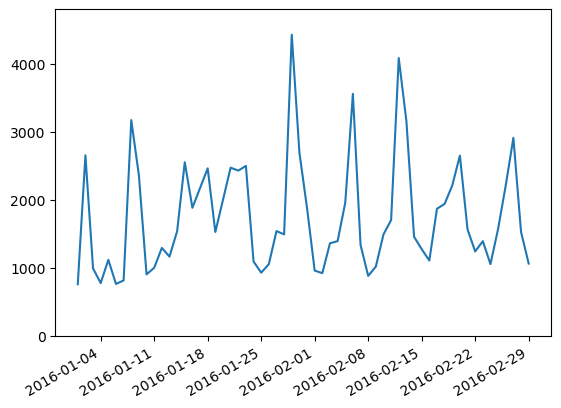

In [33]:
# Explore daily sales
daily_sales = selected_sales.groupBy('SalesDate').agg(F.sum('SalesQuantity').alias('DailySales')).orderBy('SalesDate')

dsp_df = daily_sales.toPandas()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.plot(dsp_df['SalesDate'], dsp_df['DailySales'])
plt.ylim([0,4800])
plt.gcf().autofmt_xdate()

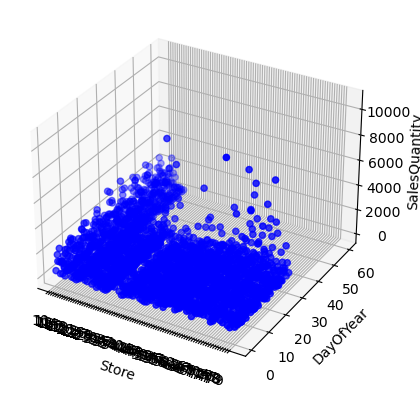

In [34]:
store_daily_sales = raw_data_sales.groupBy('Store', 'SalesDate').agg(F.sum('SalesQuantity').alias('SalesQuantity'))
store_daily_sales = store_daily_sales.withColumn('DayOfYear', F.dayofyear('SalesDate'))
dsp_df = store_daily_sales.orderBy('Store', 'DayOfYear').toPandas()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dsp_df['Store'], dsp_df['DayOfYear'], dsp_df['SalesQuantity'], c='b', marker='o')
ax.set_xlabel('Store')
ax.set_ylabel('DayOfYear')
ax.set_zlabel('SalesQuantity')
plt.show()

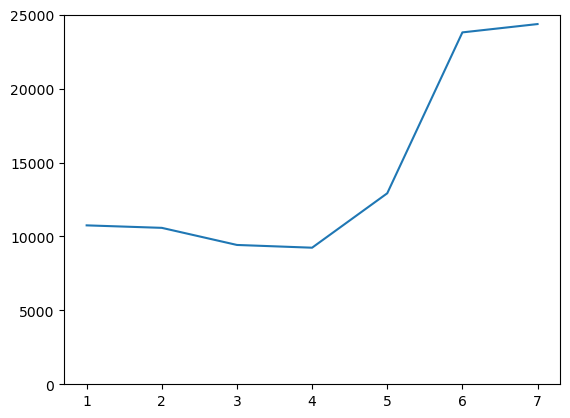

In [35]:
# Explore weekly sales
weekday_sales = selected_sales.groupby('DayOfWeek').agg(F.sum('SalesQuantity').alias('WeekdaySales')).orderBy('DayOfWeek')

dsp_df = weekday_sales.toPandas()
plt.plot(dsp_df['DayOfWeek'], dsp_df['WeekdaySales'])
plt.ylim([0, 25000])
plt.show()

##### Explore Purchase Details

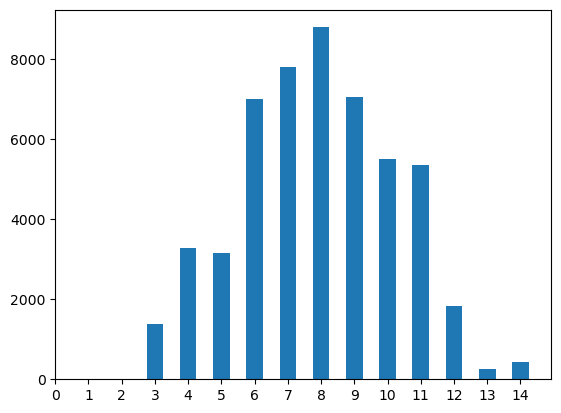

In [36]:
# Deliver Time Distribution
dsp_df = selected_purchase_detail.toPandas()
plt.hist(dsp_df['DeliverTime'], bins=[i+0.5 for i in range(0,15)], rwidth=0.5)
plt.xticks(range(0,15))
plt.show()

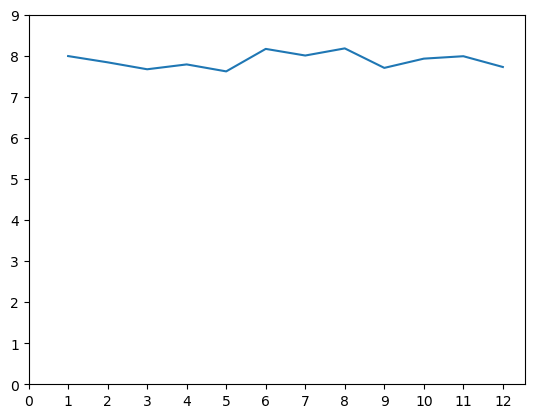

In [37]:
# Explore Montly Average Deliver Time
dsp_df = selected_purchase_detail.groupby('Month').agg(
        F.mean('DeliverTime').alias('MeanDeliveryTime')
    ).orderBy('Month').toPandas()
plt.plot(dsp_df['Month'], dsp_df['MeanDeliveryTime'])
plt.ylim([0,9])
plt.xticks(range(0,13))
plt.show()

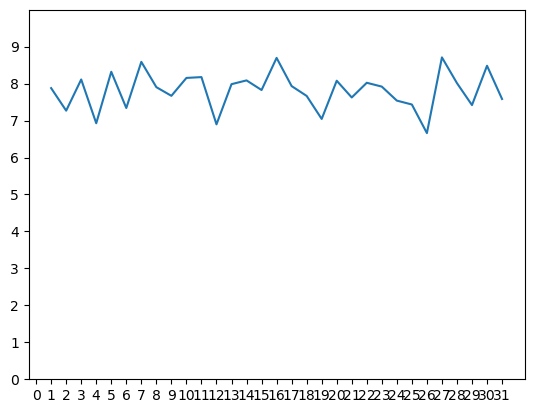

In [38]:
# Explore Daily Average Deliver Time across Months
dsp_df = selected_purchase_detail.groupby('DayOfMonth').agg(
        F.mean('DeliverTime').alias('MeanDeliveryTime')
    ).orderBy('DayOfMonth').toPandas()
plt.plot(dsp_df['DayOfMonth'], dsp_df['MeanDeliveryTime'])
plt.ylim([0,10])
plt.xticks(range(0,32))
plt.yticks(range(0,10))
plt.show()

##### Explore and Remove Extreme Values

In [39]:
# Check extremes in price field
raw_data_products.orderBy('Price', ascending=False).limit(20).show()

+-----+--------------------+-------+------+------+--------------+-------------+------------+--------------------+
|Brand|         Description|  Price|  Size|Volume|Classification|PurchasePrice|VendorNumber|          VendorName|
+-----+--------------------+-------+------+------+--------------+-------------+------------+--------------------+
| 2693|Glen Grant 50 Yr ...|13999.9| 750mL|   750|             1|     11111.03|       11567|CAMPARI AMERICA  ...|
| 3949|Patron En Lalique...|7499.99| 750mL|   750|             1|      5681.81|        9165|ULTRA BEVERAGE CO...|
| 2367|  Glenmorangie Pride|5799.99|1000mL|  1000|             1|       4264.7|        8112|MOET HENNESSY USA...|
| 1991|The Macallan M De...|4999.99| 750mL|   750|             1|      3787.87|        2561|EDRINGTON AMERICA...|
| 4423|Appleton Estate 5...|4999.99| 750mL|   750|             1|      3649.63|       11567|CAMPARI AMERICA  ...|
|  423|Hennessy Richard ...|4559.99| 750mL|   750|             1|      3352.93|        8

In [40]:
# Check extremes in volume field
raw_data_products.orderBy('Volume', ascending=False).limit(20).show()

+-----+--------------------+-------+-------+------+--------------+-------------+------------+--------------------+
|Brand|         Description|  Price|   Size|Volume|Classification|PurchasePrice|VendorNumber|          VendorName|
+-----+--------------------+-------+-------+------+--------------+-------------+------------+--------------------+
|23047|From the Tank Red...| 230.49|20000mL| 20000|             2|       149.67|       90024|VINILANDIA USA   ...|
|25463|  Eden Dry Cider Keg| 227.99|20000mL| 20000|             2|        155.1|       90047|CRUSH WINES      ...|
|23491| True Myth Chard Keg| 346.99|20000mL| 20000|             2|        204.6|       90047|CRUSH WINES      ...|
|25464| Eden Rose Cider Keg| 251.49|20000mL| 20000|             2|       163.31|       90047|CRUSH WINES      ...|
|26146|Montelvini CabMerlot| 221.99|20000mL| 20000|             2|       151.01|       90011|FORTUNE WINE BROK...|
|22565|  Clayhouse Cab Svgn| 183.99|19500mL| 19500|             2|        118.7|

In [41]:
# Check extremes in sales quantity field
raw_data_sales.orderBy('SalesQuantity', ascending=False).limit(20).show()

+-------------------+-----+-----+--------------------+---------+-------------+------------+----------+----------+------+--------------+---------+------------+--------------------+
|        InventoryId|Store|Brand|         Description|     Size|SalesQuantity|SalesDollars|SalesPrice| SalesDate|Volume|Classification|ExciseTax|VendorNumber|          VendorName|
+-------------------+-----+-----+--------------------+---------+-------------+------------+----------+----------+------+--------------+---------+------------+--------------------+
|   15_WANBORNE_8576|   15| 8576|     E & J Brandy VS|    375mL|          432|     2155.68|      4.99|2016-01-08|   375|             1|    170.1|        3252|E & J GALLO WINER...|
|   15_WANBORNE_8441|   15| 8441| Baileys Irish Cream|    375mL|          361|     4508.89|     12.49|2016-02-12|   375|             1|   142.14|        3960|DIAGEO NORTH AMER...|
|   33_HORNSEY_32831|   33|32831|Carpineto Dogajol...|    750mL|          306|     3056.94|      9.9

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9e804101d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9e80411890>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9e80402cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9e80411210>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9e80603050>],
 'means': []}

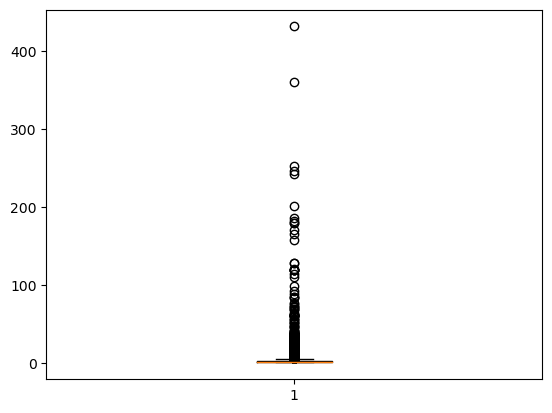

In [42]:
plt.boxplot(selected_sales.toPandas()['SalesQuantity'])

In [43]:
def remove_extreme_by_z_scores(dataframe, column, threshold = 1):
    mean, std = dataframe.agg(F.mean(column), F.stddev(column)).collect()[0]
    dataframe = dataframe.withColumn('z_scores', (F.col(column) - mean) / std)
    return dataframe.where(F.col('z_scores') <= threshold).drop('z_scores')

selected_sales = remove_extreme_by_z_scores(selected_sales, 'SalesQuantity')
selected_sales.describe('SalesQuantity').show()

+-------+------------------+
|summary|     SalesQuantity|
+-------+------------------+
|  count|             36962|
|   mean|1.9354201612466857|
| stddev|1.4654083220779113|
|    min|                 1|
|    max|                 8|
+-------+------------------+



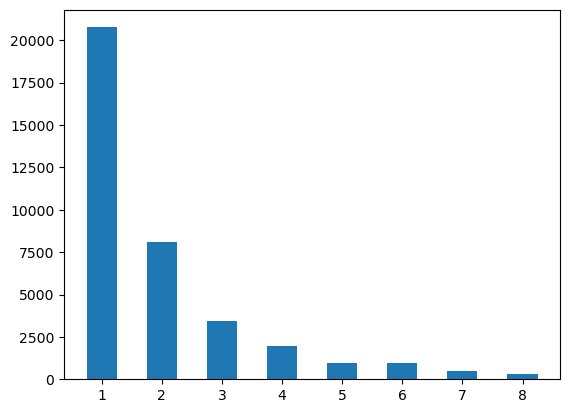

In [44]:
plt.hist(selected_sales.toPandas()['SalesQuantity'], bins=[i+0.5 for i in range(0, 9)], rwidth=0.5)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9e80633e10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9e80630650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9e80630410>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9e80465350>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9e80467190>],
 'means': []}

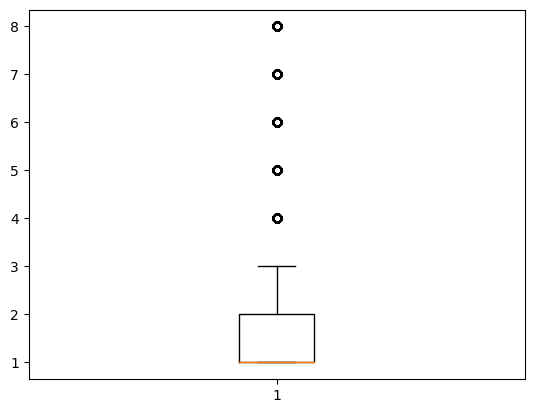

In [45]:
plt.boxplot(selected_sales.toPandas()['SalesQuantity'])

#### Integrate Purchase Detail with Products and Integrate Sales with Products

In [46]:
# Integrate product information to sales records and contruct ProfitRate fields
integrated_sales = selected_sales.join(
    selected_products.drop('Size', 'Volume', 'Classification', 'VendorNumber'), on='Brand', how='left')
integrated_sales = integrated_sales.withColumn('ProfitRate', 
    (integrated_sales['SalesPrice'] - integrated_sales['PurchasePrice']) / integrated_sales['PurchasePrice'])
integrated_sales.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesDollars: float (nullable = true)
 |-- SalesPrice: float (nullable = true)
 |-- SalesDate: date (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- ExciseTax: float (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- ProfitRate: double (nullable = true)



In [47]:
# Integrate product information to purchase details
integrated_purchase_detail = selected_purchase_detail.join(
    selected_products.drop('Size', 'VendorNumber', 'PurchasePrice', 'Classification'), on='Brand', how='left')
integrated_purchase_detail.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- PODate: date (nullable = true)
 |-- ReceivingDate: date (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: float (nullable = true)
 |-- Classification: string (nullable = true)
 |-- DeliverTime: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- Volume: integer (nullable = true)



#### Reformat DayOfWeek and Month to string

In [48]:
day_of_week_mapping = {
    1: "Sunday",
    2: "Monday",
    3: "Tuesday",
    4: "Wednesday",
    5: "Thursday",
    6: "Friday",
    7: "Saturday"
}

month_mapping = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

def convert_data_type(dataframe, column, mapping, dtype=None):
    for key, value in mapping.items():
        dataframe = dataframe.withColumn(column, F.when(F.col(column) == key, value).otherwise(F.col(column)))
    if dtype is not None:
        dataframe = dataframe.withColumn(column, F.col(column).cast(dtype))
    return dataframe

integrated_purchase_detail = convert_data_type(integrated_purchase_detail, 'Month', month_mapping, 'string')
integrated_sales = convert_data_type(integrated_sales, 'DayOfWeek', day_of_week_mapping, 'string')
integrated_sales = convert_data_type(integrated_sales, 'Month', month_mapping, 'string')

In [49]:
integrated_purchase_detail.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- PODate: date (nullable = true)
 |-- ReceivingDate: date (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: float (nullable = true)
 |-- Classification: string (nullable = true)
 |-- DeliverTime: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- Volume: integer (nullable = true)



In [50]:
integrated_sales.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesDollars: float (nullable = true)
 |-- SalesPrice: float (nullable = true)
 |-- SalesDate: date (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- ExciseTax: float (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- ProfitRate: double (nullable = true)



### Remove unsuitable features

In [51]:
# Check unique brand
integrated_sales.select('Brand').distinct().count()

3746

In [52]:
# Check the relation between Classification, SalesQuantity and ExciseTax
tmp = integrated_sales.withColumn('TotalVolume', F.col('SalesQuantity') * F.col('Volume'))

print(tmp.where('Classification = 1').corr('TotalVolume', 'ExciseTax'))
print(tmp.where('Classification = 2').corr('TotalVolume', 'ExciseTax'))

0.9999989795442092
0.9999779956562865


In [53]:
integrated_sales = integrated_sales.drop('Brand', 'SalesDollars', 'SalesDate', 'Price', 'ExciseTax')
integrated_sales.printSchema()

root
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesPrice: float (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- ProfitRate: double (nullable = true)



In [54]:
integrated_purchase_detail = integrated_purchase_detail.drop(
    'Brand', 'PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate', 'Quantity', 'Dollars')
integrated_purchase_detail.printSchema()

root
 |-- Size: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- Classification: string (nullable = true)
 |-- DeliverTime: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- Volume: integer (nullable = true)



### Transform

#### Transformation for Purchase Detail

In [55]:
integrated_purchase_detail.where('PurchasePrice <= 0 or Price <= 0 or Volume <= 0').show()

+-----+------------+-------------+--------------+-----------+---------+----------+-----+------+
| Size|VendorNumber|PurchasePrice|Classification|DeliverTime|    Month|DayOfMonth|Price|Volume|
+-----+------------+-------------+--------------+-----------+---------+----------+-----+------+
|750mL|        2561|          0.0|             1|          9|   August|        11|  0.0|   750|
|750mL|        2561|          0.0|             1|          6|September|        29|  0.0|   750|
|750mL|        2561|          0.0|             1|          9| December|         8|  0.0|   750|
+-----+------------+-------------+--------------+-----------+---------+----------+-----+------+



In [56]:
# Remove invalid records in purchase detail
integrated_purchase_detail = integrated_purchase_detail.where('PurchasePrice > 0')

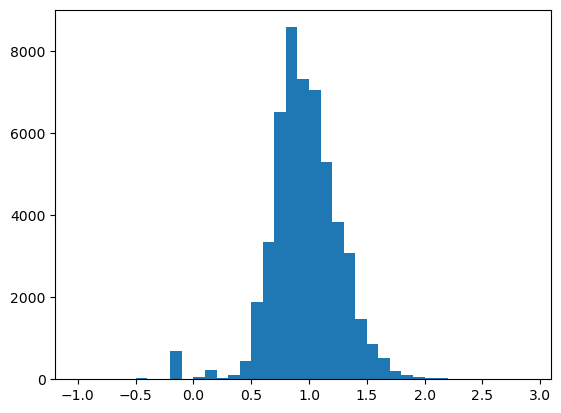

In [57]:
# Log10 transformation for Purchase Price
integrated_purchase_detail = integrated_purchase_detail.withColumn('PurchasePrice', F.log10(F.col('PurchasePrice')))
plt.hist(integrated_purchase_detail.toPandas()['PurchasePrice'], bins=[i/10 for i in range(-10,30)])
plt.show()

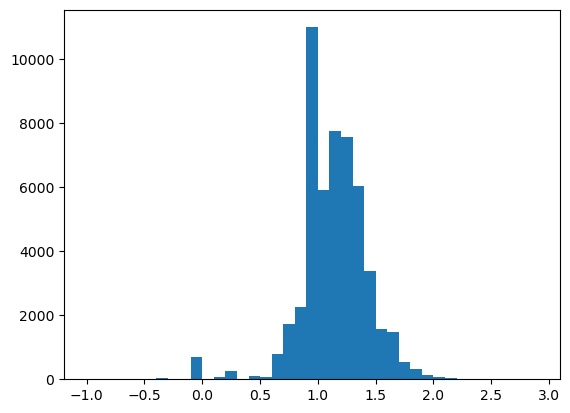

In [58]:
integrated_purchase_detail = integrated_purchase_detail.withColumn('Price', F.log10(F.col('Price')))
plt.hist(integrated_purchase_detail.toPandas()['Price'], bins=[i/10 for i in range(-10,30)])
plt.show()

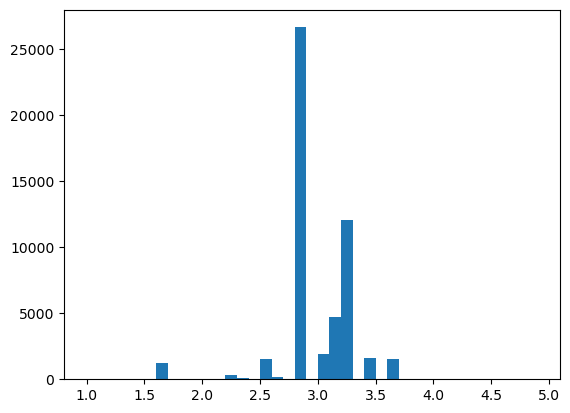

In [59]:
integrated_purchase_detail = integrated_purchase_detail.withColumn('Volume', F.log10(F.col('Volume')))
plt.hist(integrated_purchase_detail.toPandas()['Volume'], bins=[i/10 for i in range(10,50)])
plt.show()

#### Transformation for Sales

In [60]:
integrated_sales.where('PurchasePrice <=0 or SalesPrice <=0 or Volume <= 0').show()

+----+-------------+----------+------+--------------+------------+---------+----------+-----+-------------+----------+
|Size|SalesQuantity|SalesPrice|Volume|Classification|VendorNumber|DayOfWeek|DayOfMonth|Month|PurchasePrice|ProfitRate|
+----+-------------+----------+------+--------------+------------+---------+----------+-----+-------------+----------+
+----+-------------+----------+------+--------------+------------+---------+----------+-----+-------------+----------+



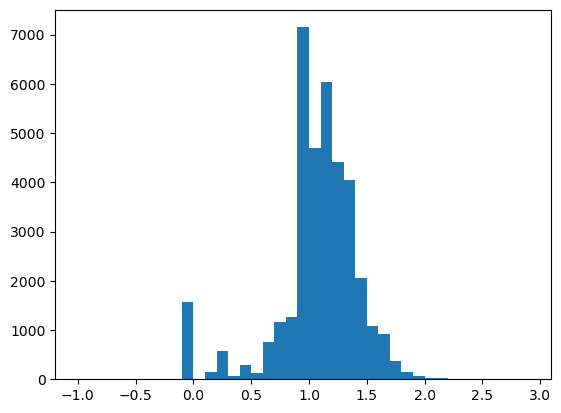

In [61]:
integrated_sales = integrated_sales.withColumn('SalesPrice', F.log10(F.col('SalesPrice')))
plt.hist(integrated_sales.toPandas()['SalesPrice'], bins=[i/10 for i in range(-10,30)])
plt.show()

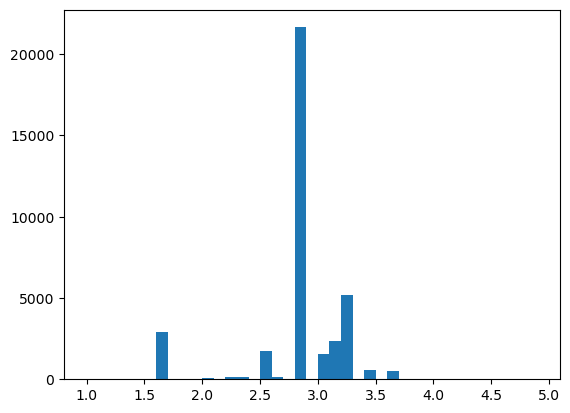

In [62]:
integrated_sales = integrated_sales.withColumn('Volume', F.log10(F.col('Volume')))
plt.hist(integrated_sales.toPandas()['Volume'], bins=[i/10 for i in range(10,50)])
plt.show()

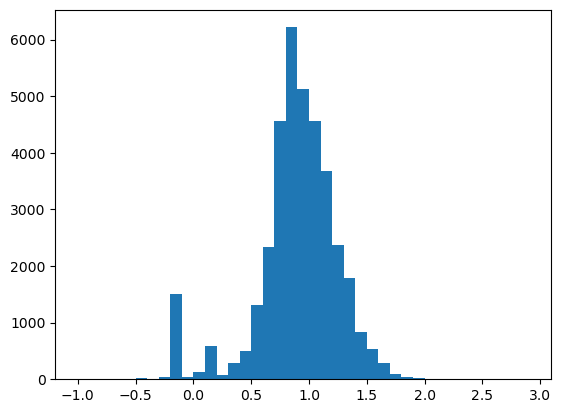

In [63]:
integrated_sales = integrated_sales.withColumn('PurchasePrice', F.log10(F.col('PurchasePrice')))
plt.hist(integrated_sales.toPandas()['PurchasePrice'], bins=[i/10 for i in range(-10,30)])
plt.show()

## Modeling

In [64]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

import tensorflow as tf
from tensorflow import keras

In [65]:
def evaluate_regression_model(result, labelCol, predictionCol='prediction', metrics = ['rmse', 'mse', 'mae', 'r2']):
    results = [(metric, 
                RegressionEvaluator(labelCol=labelCol, metricName=metric, predictionCol=predictionCol).evaluate(result)) 
               for metric in metrics]
    for metric, result in results:
        print(f'{metric}: {result}')
    return dict(results)
    
def get_string_indexers(dataframe, suffix='_index'):
    indexers = []
    for feature, dtype in dataframe.dtypes:
        if dtype == 'string':
            indexers.append(StringIndexer(inputCol=feature, outputCol=feature + suffix))
    return indexers

def generate_baseline(dataframe, target):
    target_mean = dataframe.agg(F.mean(target)).collect()[0][0]
    return dataframe.withColumn('baseline_prediction', F.lit(target_mean))

### Predicting Deliver Time

In [66]:
train, test = integrated_purchase_detail.randomSplit([0.7, 0.3], seed=13)

In [67]:
# Baseline
evaluate_regression_model(generate_baseline(test, 'DeliverTime'), 'DeliverTime', predictionCol='baseline_prediction')

rmse: 2.3293633036031793
mse: 5.425933400173117
mae: 1.8845835325306026
r2: 2.398081733190338e-14


{'rmse': 2.3293633036031793,
 'mse': 5.425933400173117,
 'mae': 1.8845835325306026,
 'r2': 2.398081733190338e-14}

Training data accuracy:
rmse: 2.3134893847482223
mse: 5.352233133342708
mae: 1.8743965765605934
r2: 0.0009663017067556012
Testing data accuracy:
rmse: 2.3288568471802984
mse: 5.42357421465856
mae: 1.8868793667534833
r2: 0.00043479809660240676


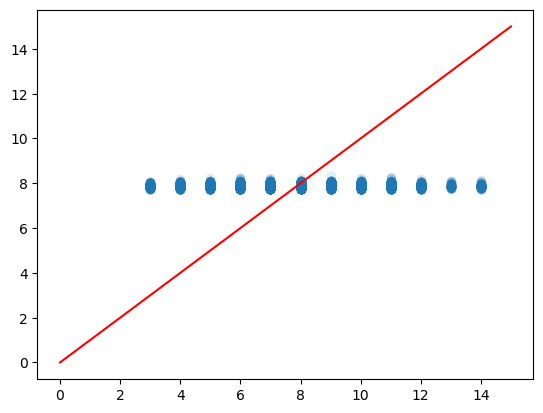

In [68]:
# Linear Regression
model_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=['PurchasePrice', 'DayOfMonth', 'Price', 'Volume'], outputCol='numeric_features'),
    LinearRegression(labelCol='DeliverTime', featuresCol='numeric_features'),
])

model = model_pipeline.fit(train)

print('Training data accuracy:')
result = model.transform(train)
evaluate_regression_model(result, 'DeliverTime')

print('Testing data accuracy:')
result = model.transform(test)
evaluate_regression_model(result, 'DeliverTime')

dsp_df = result.toPandas()
plt.scatter(dsp_df['DeliverTime'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,16), c='r')
plt.show()

Training data accuracy:
rmse: 1.5918353259398548
mse: 2.5339397049100434
mae: 1.1575584494481854
r2: 0.5270215082975385
Testing data accuracy:
rmse: 1.6910494101845122
mse: 2.859648107685387
mae: 1.2378760823562895
r2: 0.4729666037563086


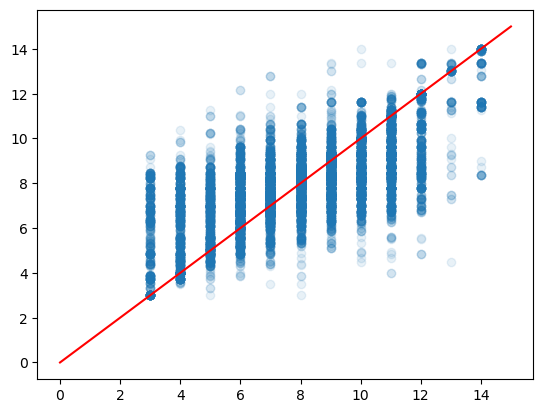

In [70]:
# Decision Tree
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_purchase_detail) + [
    VectorAssembler(inputCols=[
        'PurchasePrice', 'DayOfMonth', 'Price', 'Volume', 
        'Size_index', 'Classification_index', 'Month_index', 'VendorNumber_index'], 
                    outputCol='features')
])

dtr = DecisionTreeRegressor(maxDepth=10, labelCol='DeliverTime', featuresCol='features', maxBins=256)

transformer = transformation_pipeline.fit(integrated_purchase_detail)
model = dtr.fit(transformer.transform(train))

print('Training data accuracy:')
result = model.transform(transformer.transform(train))
evaluate_regression_model(result, 'DeliverTime')

print('Testing data accuracy:')
result = model.transform(transformer.transform(test))
evaluate_regression_model(result, 'DeliverTime')

dsp_df = result.toPandas()
plt.scatter(dsp_df['DeliverTime'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,16), c='r')
plt.show()

Training data accuracy:
rmse: 1.7666767538880923
mse: 3.1211467527285675
mae: 1.4300340277298202
r2: 0.4174149919088147
Testing data accuracy:
rmse: 1.8734550407552932
mse: 3.5098337897314176
mae: 1.5179043938179893
r2: 0.35313732571443823


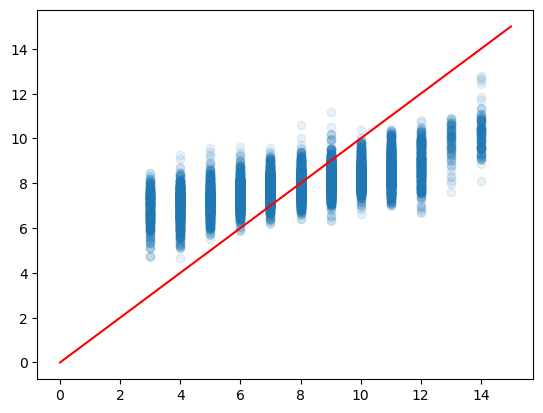

In [71]:
# Random Forest
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_purchase_detail) + [
    VectorAssembler(inputCols=[
        'PurchasePrice', 'DayOfMonth', 'Price', 'Volume', 
        'Size_index', 'Classification_index', 'Month_index', 'VendorNumber_index'], 
                    outputCol='features')
])

rfr = RandomForestRegressor(maxDepth=10, labelCol='DeliverTime', featuresCol='features', maxBins=256)

transformer = transformation_pipeline.fit(integrated_purchase_detail)
model = rfr.fit(transformer.transform(train))

print('Training data accuracy:')
result = model.transform(transformer.transform(train))
evaluate_regression_model(result, 'DeliverTime')

print('Testing data accuracy:')
result = model.transform(transformer.transform(test))
evaluate_regression_model(result, 'DeliverTime')

dsp_df = result.toPandas()
plt.scatter(dsp_df['DeliverTime'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,16), c='r')
plt.show()

### Predicting Sales

In [72]:
train, test = integrated_sales.randomSplit([0.7, 0.3], seed=13)

In [73]:
# Baseline
evaluate_regression_model(generate_baseline(test, 'SalesQuantity'), 'SalesQuantity', predictionCol='baseline_prediction')

rmse: 1.461097491828544
mse: 2.134805880627662
mae: 1.0440393748091814
r2: -9.747758156208874e-14


{'rmse': 1.461097491828544,
 'mse': 2.134805880627662,
 'mae': 1.0440393748091814,
 'r2': -9.747758156208874e-14}

Training data accuracy:
rmse: 1.4311092174215112
mse: 2.0480735921888105
mae: 1.0311858052875391
r2: 0.04858548028986598
Testing data accuracy:
rmse: 1.427537898596343
mse: 2.0378644519288627
mae: 1.0246667298153622
r2: 0.04540995018718008


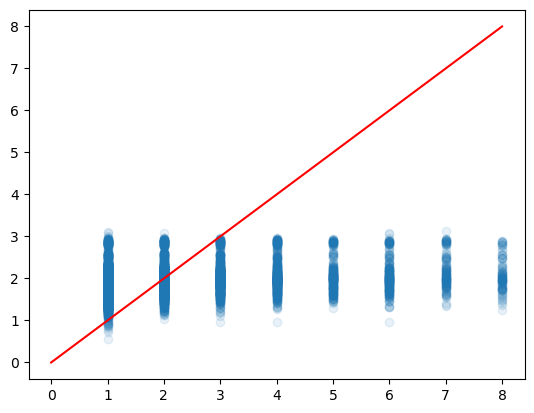

In [74]:
# Linear Regression
model_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=['SalesPrice', 'Volume', 'DayOfMonth', 'PurchasePrice', 'ProfitRate'], outputCol='numeric_features'),
    LinearRegression(labelCol='SalesQuantity', featuresCol='numeric_features'),
])

model = model_pipeline.fit(train)

print('Training data accuracy:')
result = model.transform(train)
evaluate_regression_model(result, 'SalesQuantity')

print('Testing data accuracy:')
result = model.transform(test)
evaluate_regression_model(result, 'SalesQuantity')

dsp_df = result.toPandas()
plt.scatter(dsp_df['SalesQuantity'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,9), c='r')
plt.show()

Training data accuracy:
rmse: 1.2855039029458302
mse: 1.6525202844889626
mae: 0.905449053918811
r2: 0.23233627991948758
Testing data accuracy:
rmse: 1.4096389798807023
mse: 1.9870820535991067
mae: 0.9895457157530332
r2: 0.069197779699262


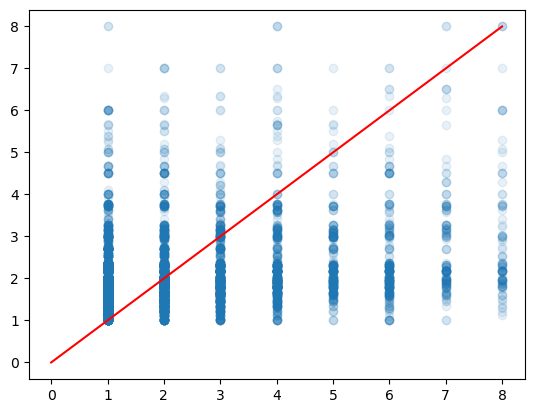

In [75]:
# Decision Tree
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice', 'Volume', 'DayOfMonth', 'PurchasePrice', 'ProfitRate',
        'Size_index', 'Classification_index', 'VendorNumber_index', 'DayOfWeek_index', 'Month_index'], 
                    outputCol='features')
])

dtr = DecisionTreeRegressor(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)

transformer = transformation_pipeline.fit(integrated_sales)
model = dtr.fit(transformer.transform(train))

print('Training data accuracy:')
result = model.transform(transformer.transform(train))
evaluate_regression_model(result, 'SalesQuantity')

print('Testing data accuracy:')
result = model.transform(transformer.transform(test))
evaluate_regression_model(result, 'SalesQuantity')

dsp_df = result.toPandas()
plt.scatter(dsp_df['SalesQuantity'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,9), c='r')
plt.show()

Training data accuracy:
rmse: 1.2667806537491464
mse: 1.6047332247131147
mae: 0.9158523522725257
r2: 0.25453533697407726
Testing data accuracy:
rmse: 1.3611991507465417
mse: 1.8528631279931067
mae: 0.9762878301694062
r2: 0.1320695034583097


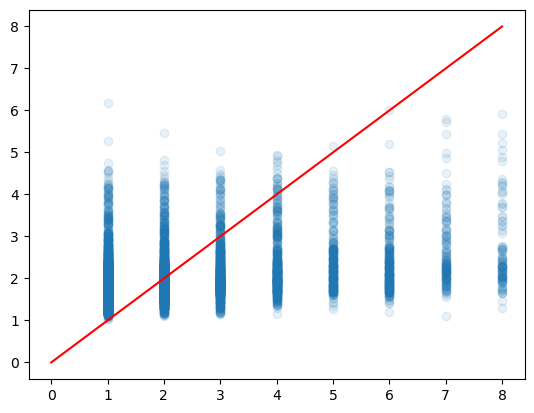

In [76]:
# Random Forest
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice', 'Volume', 'DayOfMonth', 'PurchasePrice', 'ProfitRate',
        'Size_index', 'Classification_index', 'VendorNumber_index', 'DayOfWeek_index', 'Month_index'], 
                    outputCol='features')
])

rfr = RandomForestRegressor(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)

transformer = transformation_pipeline.fit(integrated_sales)
model = rfr.fit(transformer.transform(train))

print('Training data accuracy:')
result = model.transform(transformer.transform(train))
evaluate_regression_model(result, 'SalesQuantity')

print('Testing data accuracy:')
result = model.transform(transformer.transform(test))
evaluate_regression_model(result, 'SalesQuantity')

dsp_df = result.toPandas()
plt.scatter(dsp_df['SalesQuantity'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,9), c='r')
plt.show()

## Build Final Models

In [77]:
import math

In [78]:
def print_feature_importance(model, train, rounding=6):
    attrs = train.schema["features"].metadata['ml_attr']['attrs']
    feature_names = []
    for key, feature_list in attrs.items():
        feature_names = feature_names + feature_list
    feature_importances = [(f['name'], float(round(model.featureImportances[f['idx']], rounding))) for f in feature_names]
    spark.createDataFrame(feature_importances, ['feature', 'importance']).orderBy('importance', ascending=False).show()

### Predicting Deliver Time

In [79]:
# Decision Tree
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_purchase_detail) + [
    VectorAssembler(inputCols=[
        'PurchasePrice', 'DayOfMonth', 'Price', 'Volume', 
        'Size_index', 'Classification_index', 'Month_index', 'VendorNumber_index'], 
                    outputCol='features')
])

purchase_detail_transformer = transformation_pipeline.fit(integrated_purchase_detail)

test_data_size = 1 / (math.sqrt(8) + 1)
print(f'Test data size is {test_data_size}')
train, test = integrated_purchase_detail.randomSplit([1-test_data_size, test_data_size], seed=13)

Test data size is 0.2612038749637414


In [80]:
print('Baseline performance:')
evaluate_regression_model(generate_baseline(test, 'DeliverTime'), 'DeliverTime', predictionCol='baseline_prediction', metrics=['mse', 'r2'])

cache = {}
def try_depth(max_depth):
    if cache.get(max_depth) is not None:
        return cache.get(max_depth)
    print('===============================================')
    print(f'Trying maxDepth: {max_depth}')
    dtr = DecisionTreeRegressor(maxDepth=max_depth, labelCol='DeliverTime', featuresCol='features', maxBins=256)
    model = dtr.fit(purchase_detail_transformer.transform(train))
    result = model.transform(purchase_detail_transformer.transform(test))
    cache[max_depth] = evaluate_regression_model(result, 'DeliverTime', metrics=['mse', 'r2'])
    return cache[max_depth]

def find_best_max_depth(left, right):
    if left == right:
        return left
    left_metric, right_metric = try_depth(left), try_depth(right)
    if left_metric['mse'] > right_metric['mse']:
        middle = math.ceil((left + right) / 2)
        return find_best_max_depth(middle, right)
    else:
        middle = math.floor((left + right) / 2)
        return find_best_max_depth(left, middle)

find_best_max_depth(3, 30)

Baseline performance:
mse: 5.429466916299586
r2: 8.881784197001252e-15
Trying maxDepth: 3
mse: 5.228115319643147
r2: 0.037084966122919893
Trying maxDepth: 30
mse: 0.7168284190250406
r2: 0.8679744383609609
Trying maxDepth: 17
mse: 0.8222157883921534
r2: 0.848564177465783
Trying maxDepth: 24
mse: 0.716071105184307
r2: 0.8681139205334114
Trying maxDepth: 27
mse: 0.7168284190250406
r2: 0.8679744383609609
Trying maxDepth: 25
mse: 0.716383908727219
r2: 0.8680563083317471


24

In [99]:
dtr = DecisionTreeRegressor(maxDepth=24, labelCol='DeliverTime', featuresCol='features', maxBins=256)
test_data_size = 1 / (math.sqrt(8) + 1)
train, test = integrated_purchase_detail.randomSplit([1-test_data_size, test_data_size], seed=13)
model = dtr.fit(purchase_detail_transformer.transform(train))
print('Baseline performance:')
evaluate_regression_model(generate_baseline(test, 'DeliverTime'), 'DeliverTime', predictionCol='baseline_prediction', metrics=['mse', 'r2'])
print('Training Performance:')
result = model.transform(purchase_detail_transformer.transform(train))
_ = evaluate_regression_model(result, 'DeliverTime', metrics=['mse', 'r2'])
print('Testing Performance:')
result = model.transform(purchase_detail_transformer.transform(test))
_ = evaluate_regression_model(result, 'DeliverTime', metrics=['mse', 'r2'])

Baseline performance:
mse: 5.429466916299586
r2: 8.881784197001252e-15
Training Performance:
mse: 0.00039989915586504277
r2: 0.9999253899782269
Testing Performance:
mse: 0.716071105184307
r2: 0.8681139205334114


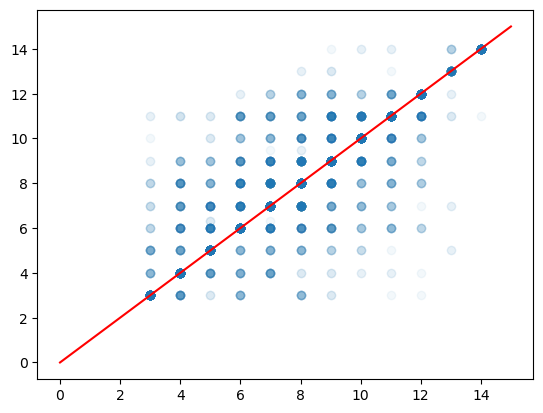

In [100]:
dsp_df = result.toPandas()
plt.scatter(dsp_df['DeliverTime'], dsp_df['prediction'], alpha=0.05)
plt.plot(range(0,16), c='r')
plt.show()

In [101]:
final_model_deliver_time = model
print_feature_importance(final_model_deliver_time, purchase_detail_transformer.transform(integrated_purchase_detail))

+--------------------+----------+
|             feature|importance|
+--------------------+----------+
|          DayOfMonth|  0.367674|
|  VendorNumber_index|  0.327327|
|         Month_index|  0.275046|
|       PurchasePrice|  0.016529|
|Classification_index|  0.005267|
|          Size_index|  0.003419|
|               Price|  0.003025|
|              Volume|  0.001713|
+--------------------+----------+



In [110]:
final_model_deliver_time.numNodes

11685

### Predicting Sales

In [84]:
# Random Forest
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice', 'Volume', 'DayOfMonth', 'PurchasePrice', 'ProfitRate',
        'Size_index', 'Classification_index', 'VendorNumber_index', 'DayOfWeek_index', 'Month_index'], 
                    outputCol='features')
])

sales_transformer = transformation_pipeline.fit(integrated_sales)

test_data_size = 1 / (math.sqrt(10) + 1)
print(f'Test data size is {test_data_size}')
train, test = integrated_sales.randomSplit([1-test_data_size, test_data_size], seed=13)

Test data size is 0.2402530733520421


In [85]:
print('Baseline performance:')
evaluate_regression_model(generate_baseline(test, 'SalesQuantity'), 
                          'SalesQuantity', predictionCol='baseline_prediction', metrics=['mse', 'r2'])
cache = {}
def try_depth(max_depth):
    if cache.get(max_depth) is not None:
        return cache.get(max_depth)
    print('===============================================')
    print(f'Trying maxDepth: {max_depth}')
    rfr = RandomForestRegressor(maxDepth=max_depth, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
    model = rfr.fit(sales_transformer.transform(train))
    result = model.transform(sales_transformer.transform(test))
    cache[max_depth] = evaluate_regression_model(result, 'SalesQuantity', metrics=['mse', 'r2'])
    return cache[max_depth]

def find_best_max_depth(left, right):
    if left == right:
        return left
    left_metric, right_metric = try_depth(left), try_depth(right)
    if left_metric['mse'] > right_metric['mse']:
        middle = math.ceil((left + right) / 2)
        return find_best_max_depth(middle, right)
    else:
        middle = math.floor((left + right) / 2)
        return find_best_max_depth(left, middle)

find_best_max_depth(3, 30)

Baseline performance:
mse: 2.134667874612771
r2: 1.2423395645555502e-13
Trying maxDepth: 3
mse: 1.977389674324585
r2: 0.0736780658756866
Trying maxDepth: 30
mse: 1.90594711810432
r2: 0.10714582780245274
Trying maxDepth: 17
mse: 1.8222494155846216
r2: 0.1463545981760972
Trying maxDepth: 23
mse: 1.8871462741004454
r2: 0.11595321382604318
Trying maxDepth: 20
mse: 1.8628374205847376
r2: 0.12734086518146281
Trying maxDepth: 18
mse: 1.836104536132496
r2: 0.13986407067406792


17

In [86]:
cache = {}
def try_num_trees(num_trees):
    if cache.get(num_trees) is not None:
        return cache.get(num_trees)
    print('===============================================')
    print(f'Trying number of trees: {num_trees}')
    rfr = RandomForestRegressor(maxDepth=17, numTrees=num_trees, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
    model = rfr.fit(sales_transformer.transform(train))
    result = model.transform(sales_transformer.transform(test))
    cache[num_trees] = evaluate_regression_model(result, 'SalesQuantity', metrics=['mse', 'r2'])
    return cache[num_trees]

def find_best_num_trees(left, right):
    if left == right:
        return left
    left_metric, right_metric = try_num_trees(left), try_num_trees(right)
    if left_metric['mse'] > right_metric['mse']:
        middle = math.ceil((left + right) / 2)
        return find_best_num_trees(middle, right)
    else:
        middle = math.floor((left + right) / 2)
        return find_best_num_trees(left, middle)

find_best_num_trees(2, 20)

Trying number of trees: 2
mse: 2.410834761787307
r2: -0.12937229742323875
Trying number of trees: 20
mse: 1.8222494155846216
r2: 0.1463545981760972
Trying number of trees: 11
mse: 1.8920125069029716
r2: 0.1136735932534948
Trying number of trees: 16
mse: 1.8443328013784996
r2: 0.1360094826400885
Trying number of trees: 18
mse: 1.8471606504041733
r2: 0.1346847571128511
Trying number of trees: 19
mse: 1.8327610790738877
r2: 0.14143033636737368


20

In [102]:
rfr = RandomForestRegressor(maxDepth=17, numTrees = 16, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
test_data_size = 1 / (math.sqrt(10) + 1)
train, test = integrated_sales.randomSplit([1-test_data_size, test_data_size], seed=13)
model = rfr.fit(sales_transformer.transform(train))
print('Baseline performance:')
evaluate_regression_model(generate_baseline(test, 'SalesQuantity'), 'SalesQuantity', predictionCol='baseline_prediction', metrics=['mse', 'r2'])
print('Training Performance:')
result = model.transform(sales_transformer.transform(train))
_ = evaluate_regression_model(result, 'SalesQuantity', metrics=['mse', 'r2'])
print('Testing Performance:')
result = model.transform(sales_transformer.transform(test))
_ = evaluate_regression_model(result, 'SalesQuantity', metrics=['mse', 'r2'])

Baseline performance:
mse: 2.134667874612771
r2: 1.2423395645555502e-13
Training Performance:
mse: 0.884283373939467
r2: 0.5889451483037257
Testing Performance:
mse: 1.8443328013784996
r2: 0.1360094826400885


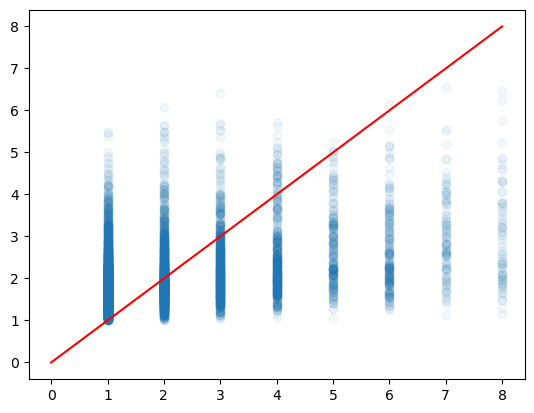

In [103]:
dsp_df = result.toPandas()
plt.scatter(dsp_df['SalesQuantity'], dsp_df['prediction'], alpha=0.05)
plt.plot(range(0,9), c='r')
plt.show()

In [104]:
final_model_sales = model
print_feature_importance(final_model_sales, sales_transformer.transform(integrated_sales))

+--------------------+----------+
|             feature|importance|
+--------------------+----------+
|          DayOfMonth|  0.175214|
|  VendorNumber_index|  0.172312|
|          ProfitRate|  0.153871|
|       PurchasePrice|  0.148641|
|     DayOfWeek_index|  0.127733|
|          SalesPrice|  0.115801|
|          Size_index|  0.039548|
|              Volume|  0.030178|
|         Month_index|  0.029382|
|Classification_index|   0.00732|
+--------------------+----------+



In [109]:
final_model_sales.totalNumNodes

139332